# Why do we need the Routh Array

In [a previous notebook](Stability%20analysis.ipynb) we showed that we can calculate the roots of the denominator of a closed loop transfer function to determine stability regions as a function of $K_c$. However, it became clear that the anlytic calculation method would only work for lower-order systems. 

Using numeric methods seemed to work OK, but involved trial-and-error.

Numeric root finding algorithms are also problematic. Consider finding the roots of $(1 + s)^{10}$. We can see that they should all be -1. Let's see how well `numpy.roots` does in finding them.

In [24]:
import numpy

In [30]:
polynomial = [1]
term = [1, 1]

In [31]:
for i in range(10):
    polynomial = numpy.convolve(polynomial, p)

In [32]:
polynomial

array([  1,  10,  45, 120, 210, 252, 210, 120,  45,  10,   1])

In [34]:
roots = numpy.roots(polynomial)
roots

array([-1.0486659 +0.01614412j, -1.0486659 -0.01614412j,
       -1.02925286+0.04166079j, -1.02925286-0.04166079j,
       -0.99899397+0.05030124j, -0.99899397-0.05030124j,
       -0.9701264 +0.03974754j, -0.9701264 -0.03974754j,
       -0.95296087+0.01496287j, -0.95296087-0.01496287j])

We're making up to 5% error and reporting non-negligable imaginary components, when we know the roots are actually real. So it's not that easy to make a call about the nature of the roots of high order polynomials by calculating them numerically. And it's not just because the algorithm isn't good enough. Evaluating one of the roots gives zero to many decimals. The problem is that computers use finite representations of these numbers.

In [36]:
numpy.polyval(polynomial, roots[0])

(-1.0769163338864018e-13+6.760217385881617e-15j)

# A better way

The [Routh-Hurwitz stabilbility criterion](https://en.wikipedia.org/wiki/Routh%E2%80%93Hurwitz_stability_criterion) provides an efficient check of stability for closed loop systems which avoids calculating the roots of a higher-order polynomial and is therefore less error prone if we have numeric coefficients and actually possible if we have symbolic coefficients (recall we cannot calculate the roots analytically for orders higher than 4).

In [39]:
import sympy

sympy.init_printing()

In [40]:
s = sympy.Symbol('s')

In [41]:
a_0, a_1, a_2, a_3, a_4 = sympy.symbols('a_0:5')
p = a_0 + a_1*s**1 + a_2*s**2 + a_3*s**3 + a_4*s**4

Note that we have to convert the expression above to a `Poly` object to recover all the coefficients.

In [42]:
p = sympy.Poly(p, s)
p

This function constructs the Routh array as given in Seborg.

In [43]:
def routh(p):
    """ Construct the Routh-Hurwitz array given a polynomial in s"""
    coefficients = p.all_coeffs()
    N = len(coefficients)
    M = sympy.zeros(N, (N+1)//2 + 1)

    r1 = coefficients[0::2]
    r2 = coefficients[1::2]
    M[0, :len(r1)] = [r1]
    M[1, :len(r2)] = [r2]
    for i in range(2, N):
        for j in range(N//2):
            S = M[[i-2, i-1], [0, j+1]]
            M[i, j] = sympy.simplify(-S.det()/M[i-1,0])
    return M[:, :-1]

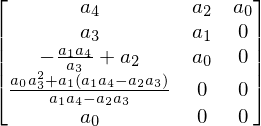

In [44]:
routh(p)

Let's try this on example 10.1

In [47]:
K_c = sympy.Symbol('K_c')

In [48]:
ce = 10*s**3 + 17*s**2 + 8*s + 1 + K_c

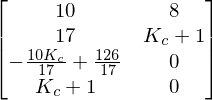

In [50]:
A = routh(sympy.Poly(ce, s))
A

For stability, the left hand column must have entries with all the same signs:

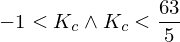

In [53]:
sympy.solve([e > 0 for e in A[:, 0]], K_c)